# InDebted DA Takehome - Keith Santos
I'll be doing an EDA to answer these 5 questions and hopefully gain more insights 

1. How should we handle the missing values for the columns age and customer_country?
2. What time of the day should we send our messages in each country?
3. What should be the preferred channel to use when communicating with customers?
4. What are the main metrics, dimensions and filters to be included in the dashboard?
5. What is the communications performance over time? What could be causing this behaviour?


In [199]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)

In [200]:
df_csv = pd.read_csv('communications.csv')#, on_bad_lines='skip')
print(df_csv["customer_id"].nunique())
print(df_csv.shape)
df_csv.head()

9751
(145941, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,28d82c62db5989d9441351f58738c6a8,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,SMS,1.0
1,0f98a1bbf7f2b66f420816a65c8d9b77,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,SMS,2.0
2,97f9ed967d2334ce0b4ebfcfc9b5c25c,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,3.0
3,3d0615ca493d69e16265ab688495c134,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,4.0
4,3eb3a03a007bd1adf7482e6d95f7b942,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,cfcd208495d565ef66e7dff9f98764da,F,NaN,51.0,2021-01-03 15:58:50.376000+00:00,SwanPay,BNPL,UK,Email,5.0


In [201]:
df_csv.dtypes

message_id           object
customer_id          object
sent_at              object
clicked               int64
converted             int64
client_id            object
gender               object
customer_country     object
age                 float64
created_at           object
client_name          object
product_type         object
client_country       object
channel              object
message_number      float64
dtype: object

## 1. How should we handle the missing values for the columns age and customer_country?
- Tried to see if splitting the UTC from the datetime and doing the value counts would yield certain values that correspond to customer_country but didn't expect so much variation for UTC 

In [202]:
df_csv.isna().sum()

message_id              0
customer_id             0
sent_at                 0
clicked                 0
converted               0
client_id               0
gender              31676
customer_country    30146
age                 22020
created_at              0
client_name             0
product_type            0
client_country          0
channel                 0
message_number          0
dtype: int64

In [203]:
df_csv['customer_country'].value_counts()

UK    49146
CA    33911
NZ    32738
Name: customer_country, dtype: int64

UTC doesn't seem to be customer country specific and some NaNs share the same UTC with only 1 other customer country but don't think it's indicative + too much work to manually check if there are 2 matches

In [204]:
df_UTCtest = pd.DataFrame(columns=['customer_country','UTC'])
df_UTCtest['customer_country'] = df_csv['customer_country'].copy()
df_UTCtest['UTC'] = df_csv['sent_at'].str.split('.').str[1].copy()

In [205]:
df_UTCtest.fillna('None', inplace=True)
df_UTCtest.head()

,customer_country,UTC
0,None,376000+00:00
1,None,376000+00:00
2,None,376000+00:00
3,None,376000+00:00
4,None,376000+00:00


In [206]:
df_UTCtest['customer_country'].value_counts()

UK      49146
CA      33911
NZ      32738
None    30146
Name: customer_country, dtype: int64

Comparing the means and medians of the messages each person receives comparing ones that have missing info values and the ones that don't

In [207]:
df_missing_customercountries = df_csv.loc[df_csv['customer_country'].isna()].copy()
df_missing_customercountries.shape

(30146, 15)

In [208]:
df_complete_customercountries = df_csv.loc[df_csv['customer_country'].notnull()].copy()
df_complete_customercountries.shape

(115795, 15)

In [209]:
column_holder = 'customer_id'

print(df_missing_customercountries[column_holder].value_counts().mean())
print(df_csv[column_holder].value_counts().mean())
print(df_complete_customercountries[column_holder].value_counts().mean())

print(df_missing_customercountries[column_holder].value_counts().median())
print(df_csv[column_holder].value_counts().median())
print(df_complete_customercountries[column_holder].value_counts().median())

15.891407485503427
14.966772638703723
14.743442831678125
14.0
13.0
12.0


In [210]:
df_missing_valcounts = pd.DataFrame(columns=['messages_per_person'])
df_complete_valcounts = pd.DataFrame(columns=['messages_per_person'])

df_missing_valcounts["messages_per_person"] = df_missing_customercountries[column_holder].value_counts().values
df_complete_valcounts["messages_per_person"] = df_complete_customercountries[column_holder].value_counts().values

print(df_missing_valcounts.shape)
print(df_complete_valcounts.shape)

(1897, 1)
(7854, 1)


Mann Whitney U test shows a statistically significant p when comparing the samples of numbers of messages per person that have missing customer country vs that don't have missing customer country

<AxesSubplot: >

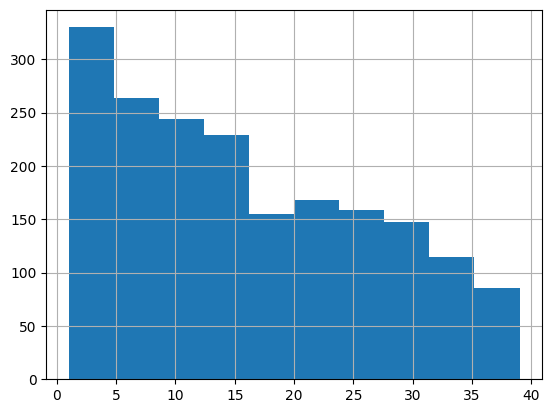

In [211]:
df_missing_valcounts["messages_per_person"].hist()

<AxesSubplot: >

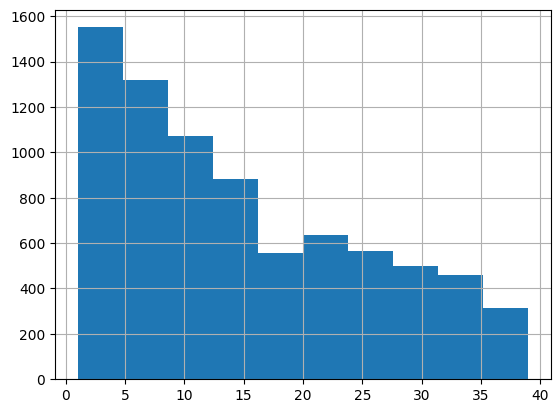

In [212]:
df_complete_valcounts["messages_per_person"].hist()

Decided not to fill in / remove any of the missing values or rows (age, country, gender) because the dashboard graphs seem cohesive enough without them and the large amount of missing values may skew the data if filled inaccurately. 

## 2. What time of the day should we send our messages in each country?

In [213]:
df_csv['sent_at'] = pd.to_datetime(df_csv['sent_at'], errors='coerce')
df_csv.dtypes

message_id                       object
customer_id                      object
sent_at             datetime64[ns, UTC]
clicked                           int64
converted                         int64
client_id                        object
gender                           object
customer_country                 object
age                             float64
created_at                       object
client_name                      object
product_type                     object
client_country                   object
channel                          object
message_number                  float64
dtype: object

In [214]:
# df containing rows which the message was clicked OR replied to
df_clicked_converted = df_csv.loc[(df_csv['clicked'] == 1) | (df_csv['converted'] == 1 )].copy()
df_clicked_converted.reset_index(inplace=True, drop=True)

print(df_clicked_converted["customer_id"].nunique())
print(df_clicked_converted.shape)
df_clicked_converted.head()

6086
(9374, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,b362af6f8c490377462744f70a524665,26c5f8755c296b92685959c57114ba75,2021-04-28 11:50:25.127000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,NZ,28.0,2021-01-03 16:55:05.127000+00:00,SwanPay,BNPL,UK,Email,17.0
1,97863b5325e02095b46eede5430df32f,26c5f8755c296b92685959c57114ba75,2021-06-17 10:25:45.127000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,NZ,28.0,2021-01-03 16:55:05.127000+00:00,SwanPay,BNPL,UK,Email,24.0
2,3aa8304b816ebf485ee3068e47e62ff3,26c5f8755c296b92685959c57114ba75,2021-09-03 09:52:09.127000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,NZ,28.0,2021-01-03 16:55:05.127000+00:00,SwanPay,BNPL,UK,Email,35.0
3,40684a56c92c67e11c2800e2e423e9c3,06e72df8cce37d99724e98a89ff031e0,2021-01-13 15:48:51.167000+00:00,1,0,cfcd208495d565ef66e7dff9f98764da,F,UK,24.0,2021-01-03 18:20:36.167000+00:00,SwanPay,BNPL,UK,Email,2.0
4,e4f91bd680bb8c2ff2489a016527465c,06e72df8cce37d99724e98a89ff031e0,2021-01-19 09:04:59.167000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,24.0,2021-01-03 18:20:36.167000+00:00,SwanPay,BNPL,UK,Email,3.0


In [215]:
# df containing rows which the message was replied to
df_converted = df_csv.loc[(df_csv['converted'] == 1 )].copy()
df_converted.reset_index(inplace=True, drop=True)

print(df_converted["customer_id"].nunique())
print(df_converted.shape)
df_converted.head()

3142
(3142, 15)


,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number
0,e4f91bd680bb8c2ff2489a016527465c,06e72df8cce37d99724e98a89ff031e0,2021-01-19 09:04:59.167000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,24.0,2021-01-03 18:20:36.167000+00:00,SwanPay,BNPL,UK,Email,3.0
1,177d6b78abf38591b5352177e2e4cbbb,6c106790e67f6988b943e6971cbe1d04,2021-07-08 15:45:25.423000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,NaN,29.0,2021-01-01 08:52:53.423000+00:00,SwanPay,BNPL,UK,SMS,27.0
2,798cfc63f3a821ff919bb74cc42240ac,15c286543a1dbf6ab2c855747f751cb7,2021-09-15 12:17:59.064000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,NaN,NaN,27.0,2021-01-01 01:49:55.064000+00:00,SwanPay,BNPL,UK,Email,36.0
3,82fd83a85b4154c2de4c01459d8b8123,ab93a807d958811fdcf7e1f8fc39bd2a,2021-02-26 10:06:20.605000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,NaN,2021-01-03 21:58:36.605000+00:00,SwanPay,BNPL,UK,Email,8.0
4,9238b01b87d0121a97d36dda6b7507a0,abd9d49a461b10861017f60f1b4770d9,2021-05-31 17:23:34.681000+00:00,1,1,cfcd208495d565ef66e7dff9f98764da,F,UK,19.0,2021-01-03 00:00:36.681000+00:00,SwanPay,BNPL,UK,Email,22.0


Interesting to see that **3142 / 9751 (32.22%) customers eventually respond** but **only 9374 / 145941 (6.42%) of messages are either clicked or responded to**. It seems that **out of the users that do engage with the comapany (click OR respond), only 3142 / 6086 (51.53%) lead to a conversation**, which I assume is the "success" factor since there have been rows with the same user clicking and not responding but that leads to more messages sent to them until they either do respond or a message threshold (35+) is reached.

In [216]:
# Monday = 0 Sunday = 6
df_converted["day_of_week_sent"] = df_converted["sent_at"].dt.weekday.copy()
df_converted["day_of_week_sent"].value_counts()

3    748
1    716
2    679
4    676
0    323
Name: day_of_week_sent, dtype: int64

<AxesSubplot: xlabel='day_of_week_sent', ylabel='converted'>

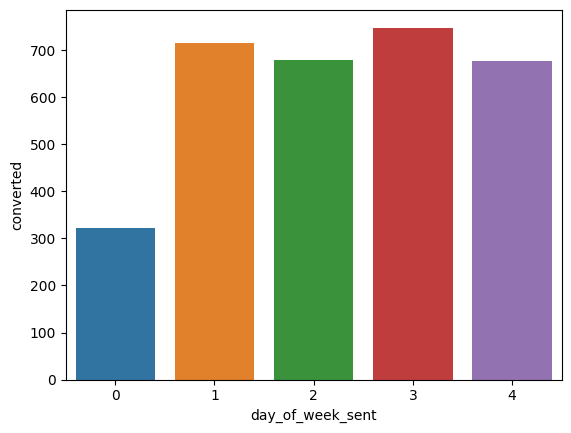

In [217]:
df_dayofweek_aggregate = df_converted.groupby(by=["day_of_week_sent"]).sum(numeric_only=True)
df_dayofweek_aggregate.reset_index(inplace=True, drop=False)
sns.barplot(data=df_dayofweek_aggregate, x='day_of_week_sent', y='converted')

In [218]:
df_converted["hour_sent"] = df_converted["sent_at"].dt.hour.copy()
df_converted["hour_sent"].value_counts()

10    679
9     642
11    589
8     193
14    154
16    152
15    142
12    140
13    124
18    113
17    110
19    104
Name: hour_sent, dtype: int64

<AxesSubplot: xlabel='hour_sent', ylabel='converted'>

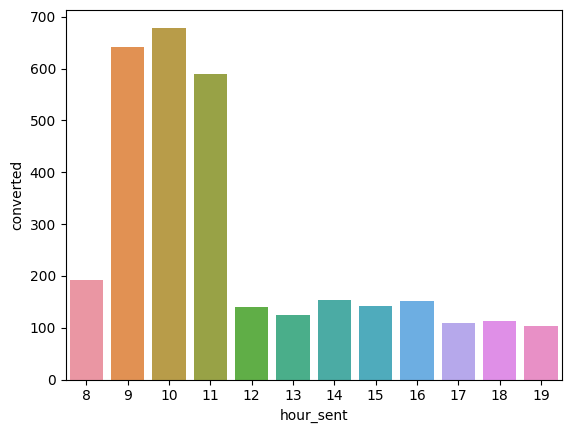

In [219]:
df_hour_aggregate = df_converted.groupby(by=["hour_sent"]).sum(numeric_only=True)
df_hour_aggregate.reset_index(inplace=True, drop=False)
sns.barplot(data=df_hour_aggregate, x='hour_sent', y='converted')

### Looking into separating the replied messages via hour and country

In [220]:
def conversions_location_aggregate(dataframe, country, column_name):
    """
    dataframe = source dataframe
    column_name = categorical column where we'll aggregate it by each country (CA, NZ, UK)
    
    - this function uses the dataframe with only the rows of people with converted == 1 or those who responded 
    - a holder dataframe is used to get the rows with the indicated country and groupby the given column, giving the sum of values
    - it is then plotted out
    
    """
    
    df_country_filtered = dataframe.loc[(dataframe['customer_country'] == country)].copy()
    df_country_filtered_hour_aggregate = df_country_filtered.groupby(by=[column_name]).sum(numeric_only=True)
    df_country_filtered_hour_aggregate.reset_index(inplace=True, drop=False)
    
    plot = sns.barplot(data=df_country_filtered_hour_aggregate, x=column_name, y='converted')
    plot.set_title(f'{column_name} response counts for people in {country}', fontsize=14, fontweight="bold", y=1.01)

In [221]:
df_converted["customer_country"].value_counts()

CA    1336
UK     990
NZ     321
Name: customer_country, dtype: int64

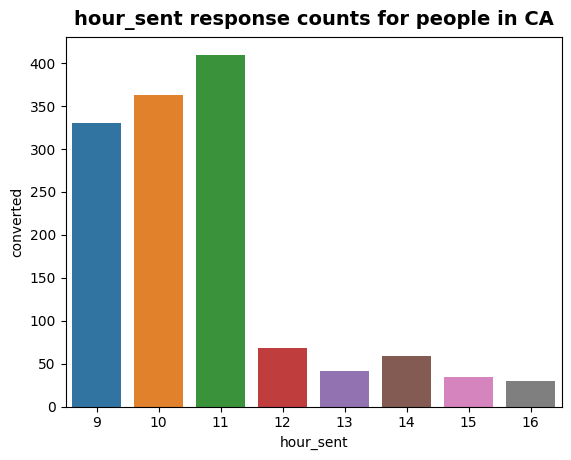

In [222]:
conversions_location_aggregate(df_converted, "CA", "hour_sent")

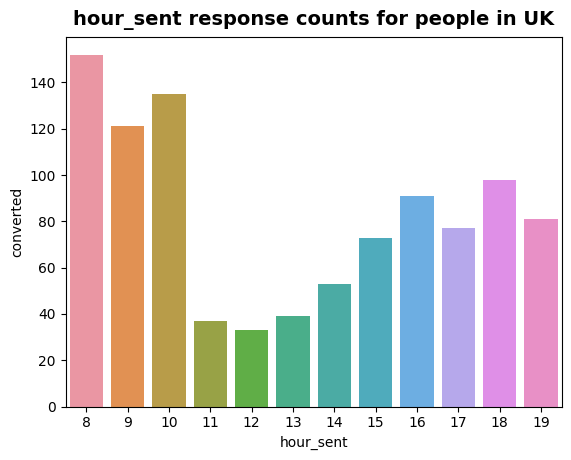

In [223]:
conversions_location_aggregate(df_converted, "UK", "hour_sent")

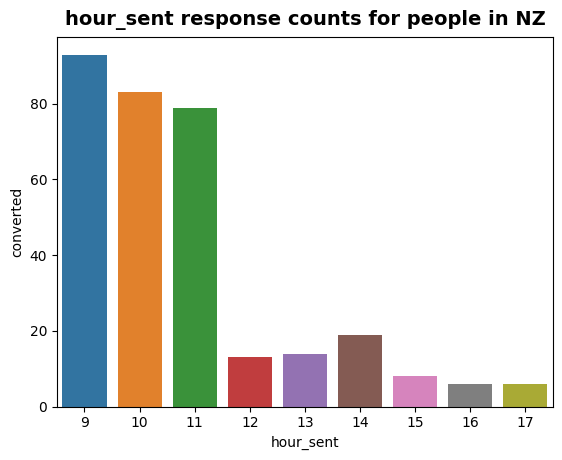

In [224]:
conversions_location_aggregate(df_converted, "NZ", "hour_sent")

## 3. What should be the preferred channel to use when communicating with customers?

In [225]:
df_channel_aggregate = df_converted.groupby(by=["channel"]).sum(numeric_only=True)
df_channel_aggregate.reset_index(inplace=True, drop=False)
df_channel_aggregate
#sns.barplot(data=df_dayofweek_aggregate, x='day_of_week_sent', y='converted')

,channel,clicked,converted,age,message_number,day_of_week_sent,hour_sent
0,Email,1916,1916,58391.0,19686.0,4231,22255
1,SMS,1226,1226,37695.0,12877.0,2791,14226


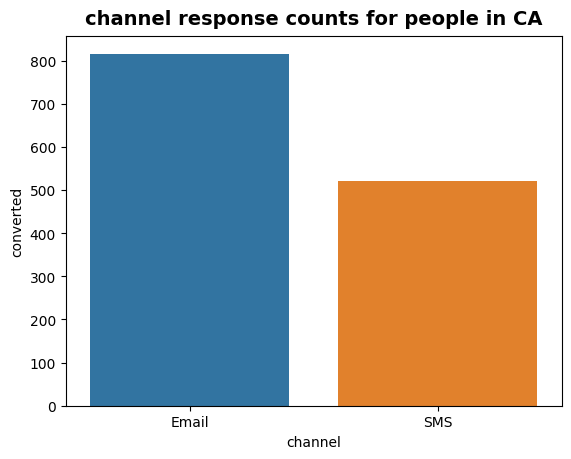

In [226]:
conversions_location_aggregate(df_converted, "CA", "channel")

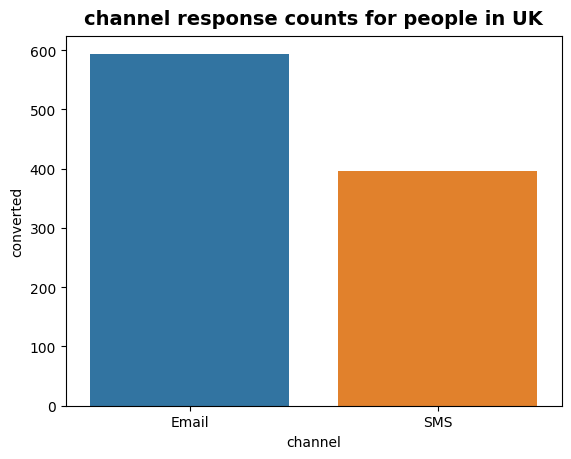

In [227]:
conversions_location_aggregate(df_converted, "UK", "channel")

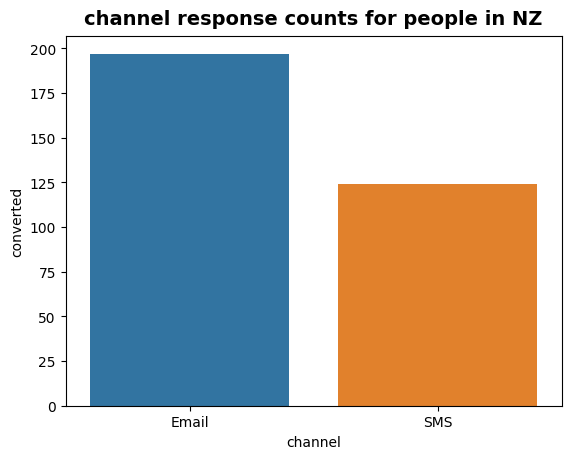

In [228]:
conversions_location_aggregate(df_converted, "NZ", "channel")

## 5. What is the communications performance over time? What could be causing this behaviour?

In [229]:
print(df_csv["sent_at"].min())
print(df_csv["sent_at"].max())

2021-01-04 10:03:16.376000+00:00
2021-10-01 19:58:46.086000+00:00


In [230]:
df_timeslice = df_csv.filter(['customer_id','sent_at','clicked', 'converted', 'customer_country', 'message_number'], axis=1)
df_timeslice.head()

,customer_id,sent_at,clicked,converted,customer_country,message_number
0,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,NaN,1.0
1,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,NaN,2.0
2,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,NaN,3.0
3,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,NaN,4.0
4,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,NaN,5.0


Will look into how many days on average is spent messaging a person then will try to see if the average per yearly quarter shortens or remainds consistent. Might separate this by ones that respond and ones that don't

In [231]:
df_timeslice['message_day_intervals'] = df_timeslice.groupby('customer_id')['sent_at'].diff() / np.timedelta64(1, 'D')
df_timeslice['message_day_intervals'].fillna(0, inplace=True)
df_timeslice.head()

,customer_id,sent_at,clicked,converted,customer_country,message_number,message_day_intervals
0,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-04 10:03:16.376000+00:00,0,0,NaN,1.0,0.000000
1,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-12 08:34:09.376000+00:00,0,0,NaN,2.0,7.938113
2,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-19 08:58:11.376000+00:00,0,0,NaN,3.0,7.016690
3,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-01-28 10:43:04.376000+00:00,0,0,NaN,4.0,9.072836
4,f13e966f9dc1e2aa7bffec6c9efa8e11,2021-02-04 11:28:56.376000+00:00,0,0,NaN,5.0,7.031852


In [232]:
df_timeslice_intervals_aggregate = df_timeslice.groupby(by=["customer_id"]).sum(numeric_only=True)
df_timeslice_intervals_aggregate["message_day_intervals"] = df_timeslice_intervals_aggregate["message_day_intervals"].round(decimals = 1)
df_timeslice_intervals_aggregate.reset_index(inplace=True, drop=False)

print(df_timeslice_intervals_aggregate.shape)
df_timeslice_intervals_aggregate.head()

(9751, 5)


,customer_id,clicked,converted,message_number,message_day_intervals
0,00043de85b74cba03f23dfe600b781bb,0,0,45.0,54.0
1,0004a5f5de52a32daabb66e9c69ca05a,3,0,595.0,229.9
2,0021b8a5c5747c1b2cdca92c54d68d2b,0,0,153.0,110.8
3,002cb5e3ce196755e4705e3ce2253077,1,1,105.0,88.7
4,0033da85f997a74fdffc322dc6f6d217,0,0,171.0,118.1


In [233]:
print("Mean days per person for the FULL DATASET: %s " % (df_timeslice_intervals_aggregate["message_day_intervals"].mean()))
print("Mean days per person for people who RESPONDED: %s " % (df_timeslice_intervals_aggregate["message_day_intervals"].loc[(df_timeslice_intervals_aggregate['converted'] == 1)].mean()))
print("Mean days per person for people who DIDN'T RESPOND: %s " % (df_timeslice_intervals_aggregate["message_day_intervals"].loc[(df_timeslice_intervals_aggregate['converted'] == 0)].mean()))

print("Median days per person for the FULL DATASET: %s " % (df_timeslice_intervals_aggregate["message_day_intervals"].median()))
print("Median days per person for people who RESPONDED: %s " % (df_timeslice_intervals_aggregate["message_day_intervals"].loc[(df_timeslice_intervals_aggregate['converted'] == 1)].median()))
print("Median days per person for people who DIDN'T RESPOND: %s " % (df_timeslice_intervals_aggregate["message_day_intervals"].loc[(df_timeslice_intervals_aggregate['converted'] == 0)].median()))

Mean days per person for the FULL DATASET: 98.629720028715 
Mean days per person for people who RESPONDED: 66.06155315085933 
Mean days per person for people who DIDN'T RESPOND: 114.1130276895143 
Median days per person for the FULL DATASET: 83.8 
Median days per person for people who RESPONDED: 51.8 
Median days per person for people who DIDN'T RESPOND: 105.0 


<AxesSubplot: xlabel='converted', ylabel='message_day_intervals'>

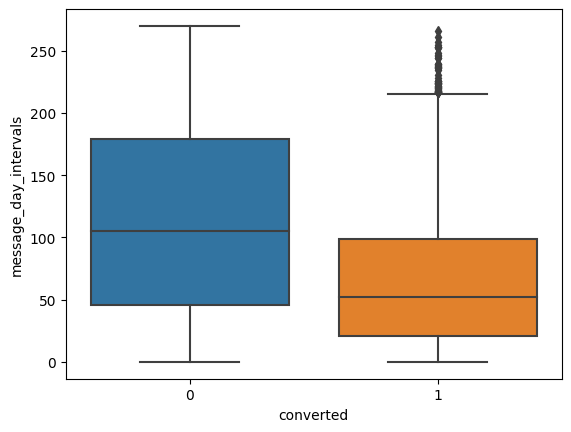

In [234]:
sns.boxplot(x="converted", y="message_day_intervals", data=df_timeslice_intervals_aggregate)

Noticeable difference in the average / median number of total days "spent" on each customer based on if they end up responding or not. The ones that don't respond take up almost double the number of days on average to respond and that seems like it can be improved because time is money

but how do you determine which is which before it happens? how do you also prevent ghosting from happening? 

In [235]:
df_max_messages = pd.DataFrame(df_timeslice.groupby(['customer_id'], sort=False)['message_number'].max())
df_max_messages.sort_values(by=["customer_id"], inplace=True)
df_max_messages.reset_index(inplace=True, drop=False)
df_max_messages.head()

,customer_id,message_number
0,00043de85b74cba03f23dfe600b781bb,9.0
1,0004a5f5de52a32daabb66e9c69ca05a,34.0
2,0021b8a5c5747c1b2cdca92c54d68d2b,17.0
3,002cb5e3ce196755e4705e3ce2253077,14.0
4,0033da85f997a74fdffc322dc6f6d217,18.0


In [236]:
df_timeslice_intervals_aggregate["highest_message_number"] = df_max_messages["message_number"].copy()
df_timeslice_intervals_aggregate.head()

,customer_id,clicked,converted,message_number,message_day_intervals,highest_message_number
0,00043de85b74cba03f23dfe600b781bb,0,0,45.0,54.0,9.0
1,0004a5f5de52a32daabb66e9c69ca05a,3,0,595.0,229.9,34.0
2,0021b8a5c5747c1b2cdca92c54d68d2b,0,0,153.0,110.8,17.0
3,002cb5e3ce196755e4705e3ce2253077,1,1,105.0,88.7,14.0
4,0033da85f997a74fdffc322dc6f6d217,0,0,171.0,118.1,18.0


In [237]:
print("Mean Messages per person for people who RESPONDED: %s " % (df_timeslice_intervals_aggregate["highest_message_number"].loc[(df_timeslice_intervals_aggregate['converted'] == 1)].mean()))
print("Mean Messages per person for people who DIDN'T RESPOND: %s " % (df_timeslice_intervals_aggregate["highest_message_number"].loc[(df_timeslice_intervals_aggregate['converted'] == 0)].mean()))

print("Median Messages per person for people who RESPONDED: %s " % (df_timeslice_intervals_aggregate["highest_message_number"].loc[(df_timeslice_intervals_aggregate['converted'] == 1)].median()))
print("Median Messages per person for people who DIDN'T RESPOND: %s " % (df_timeslice_intervals_aggregate["highest_message_number"].loc[(df_timeslice_intervals_aggregate['converted'] == 0)].median()))

Mean Messages per person for people who RESPONDED: 10.363781031190324 
Mean Messages per person for people who DIDN'T RESPOND: 17.15509154183689 
Median Messages per person for people who RESPONDED: 8.0 
Median Messages per person for people who DIDN'T RESPOND: 16.0 


mean number of messages PER person!!! a while ago it focused on time spent on a person and this time it's how many messages on average. The results seem consistent that people who don't reply require almost double the messages since it is not guaranteed if they'll even reply

## #.Random Exploration

In [238]:
"""
the dataframe "df_last_messages" is based on if each customer replies or not whereas the graphs above represent only the customers that replied

"""
df_last_messages = df_csv.copy()
df_last_messages = df_hoho.sort_values('message_number', ascending=False).drop_duplicates(["customer_id"])
df_last_messages.sort_values(by=["customer_id"], inplace=True)
df_last_messages.reset_index(inplace=True, drop=True)
df_last_messages["total_message_days"] = df_timeslice_intervals_aggregate["message_day_intervals"].copy()
df_last_messages.head()

,message_id,customer_id,sent_at,clicked,converted,client_id,gender,customer_country,age,created_at,client_name,product_type,client_country,channel,message_number,total_message_days
0,18e91807e44601cc354e0438de23ec49,00043de85b74cba03f23dfe600b781bb,2021-09-28 09:15:05.836000+00:00,0,0,c81e728d9d4c2f636f067f89cc14862c,F,UK,64.0,2021-07-28 20:32:40.836000+00:00,Badgerbank,CreditCard,UK,Email,9.0,54.0
1,630bed081fc98777bf6dc40a130047ff,0004a5f5de52a32daabb66e9c69ca05a,2021-09-29 09:45:16.913000+00:00,0,0,eccbc87e4b5ce2fe28308fd9f2a7baf3,M,NZ,28.0,2021-02-01 08:03:56.913000+00:00,KiwiPay,BNPL,NZ,SMS,34.0,229.9
2,840a7a84db4f789a5240a5a9b18495e0,0021b8a5c5747c1b2cdca92c54d68d2b,2021-09-28 10:24:19.694000+00:00,0,0,a87ff679a2f3e71d9181a67b7542122c,F,NZ,63.0,2021-06-04 21:00:23.694000+00:00,Skink Solar,Energy,NZ,Email,17.0,110.8
3,1fd6a6f2cb3717b57d9cc4f42c1cc119,002cb5e3ce196755e4705e3ce2253077,2021-07-07 10:14:27.494000+00:00,1,1,1679091c5a880faf6fb5e6087eb1b2dc,F,CA,19.0,2021-03-31 21:42:19.494000+00:00,Moose Money,BNPL,CA,Email,14.0,88.7
4,95a25a4c385c238adca84f5c94582ce4,0033da85f997a74fdffc322dc6f6d217,2021-09-29 12:58:55.814000+00:00,0,0,c4ca4238a0b923820dcc509a6f75849b,NaN,UK,57.0,2021-05-28 03:00:43.814000+00:00,Fox Energy,Energy,UK,Email,18.0,118.1


## I saved df_last_messages as "communications_unique_ids.csv" and also used that for the tableau dashboard - along with the original "communications.csv"

<AxesSubplot: >

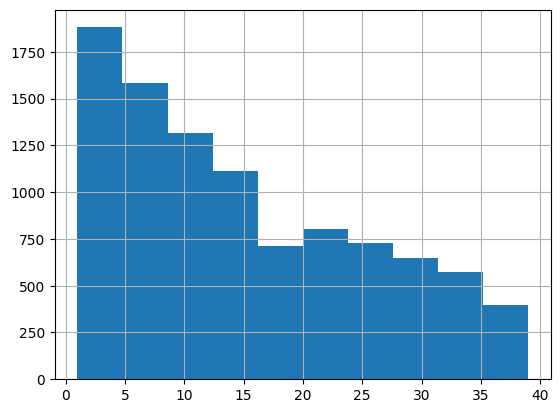

In [251]:
df_last_messages["message_number"].hist()

<AxesSubplot: >

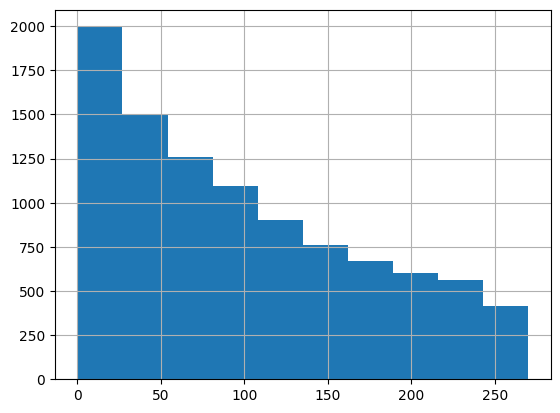

In [252]:
df_last_messages["total_message_days"].hist()

Non-normal distributions for **message_number** and **total_message_days** so will use Median instead of Mean 

In [239]:
def categorical_converted_splitter(dataframe, column_name):
    """
    dataframe = source dataframe
    column_name = categorical column where we'll split it by converted 0's and 1's then do a value counts
    
    - this will create separate dataframes for the categorical values, one wherein the customer responded and one where they didn't
    - both dataframes are left joined then are plotted
    
    """
    df_responded = pd.DataFrame(dataframe[column_name].loc[(dataframe['converted'] == 1)].value_counts())
    df_responded.reset_index(inplace=True, drop=False)
    df_responded.rename(columns={'index': column_name, column_name: "responded"}, inplace=True)
    
    df_ghosted = pd.DataFrame(dataframe[column_name].loc[(dataframe['converted'] == 0)].value_counts())
    df_ghosted.reset_index(inplace=True, drop=False)
    df_ghosted.rename(columns={'index': column_name, column_name: "ghosted"}, inplace=True)
    
    df_responded = df_responded.merge(df_ghosted, on=column_name, how='left')
    df_responded.plot(x=column_name, y=['ghosted', 'responded'], kind='bar', color=['tab:blue', 'tab:orange'],figsize=(9, 8))

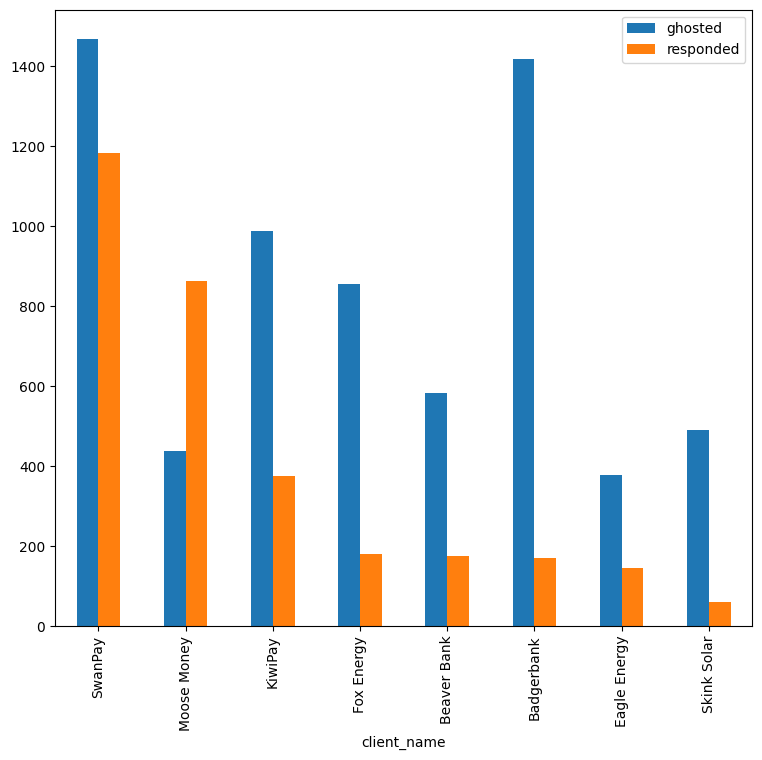

In [240]:
categorical_converted_splitter(df_last_messages, "client_name")

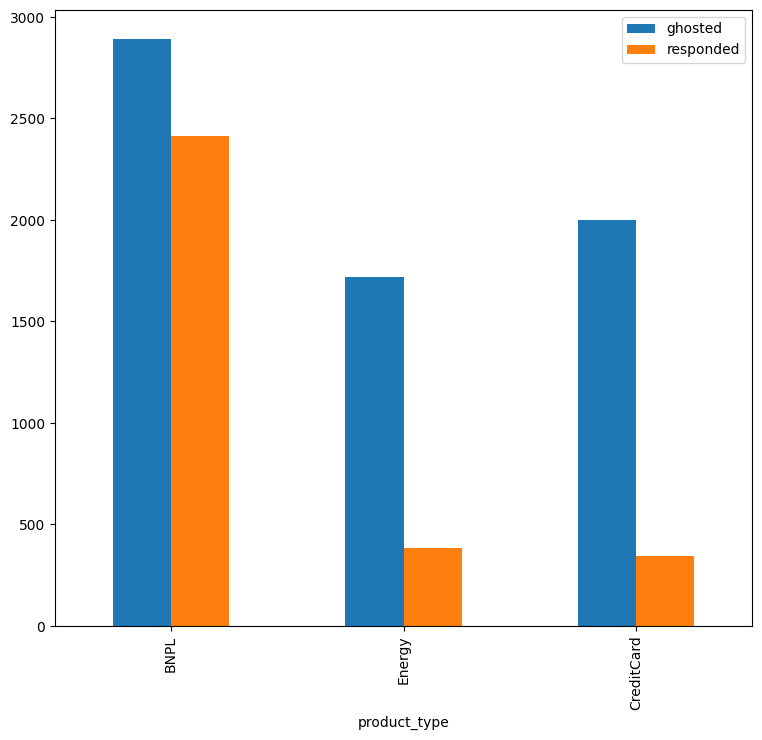

In [241]:
categorical_converted_splitter(df_last_messages, "product_type")

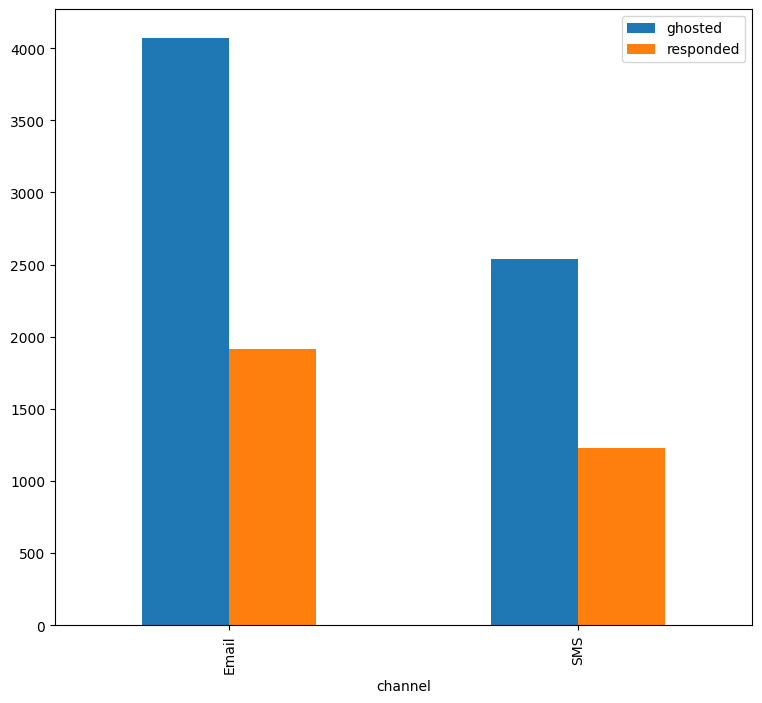

In [242]:
categorical_converted_splitter(df_last_messages, "channel")

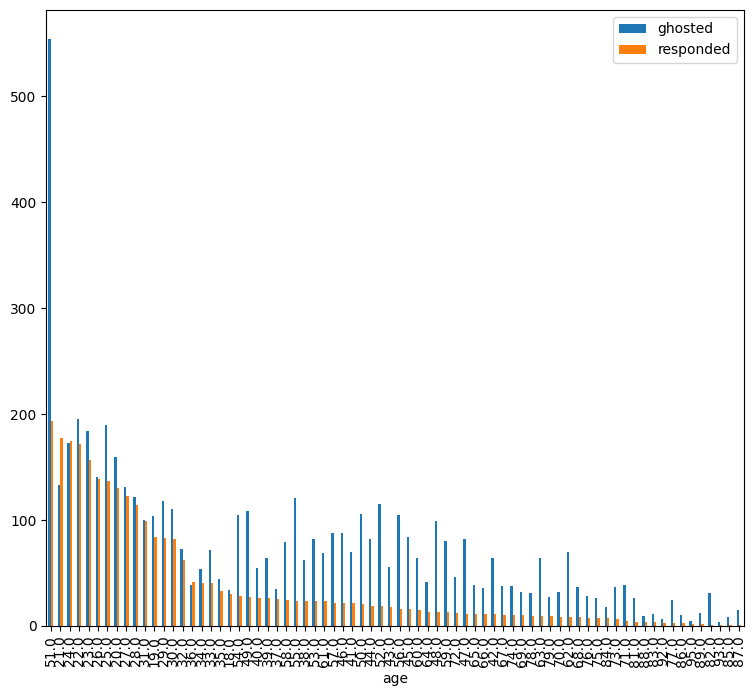

In [243]:
categorical_converted_splitter(df_last_messages, "age")

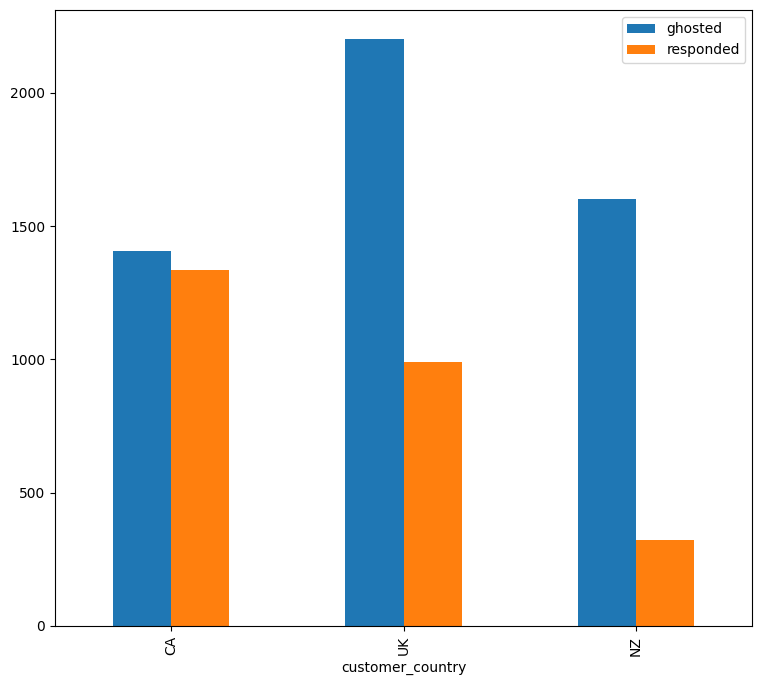

In [244]:
categorical_converted_splitter(df_last_messages, "customer_country")

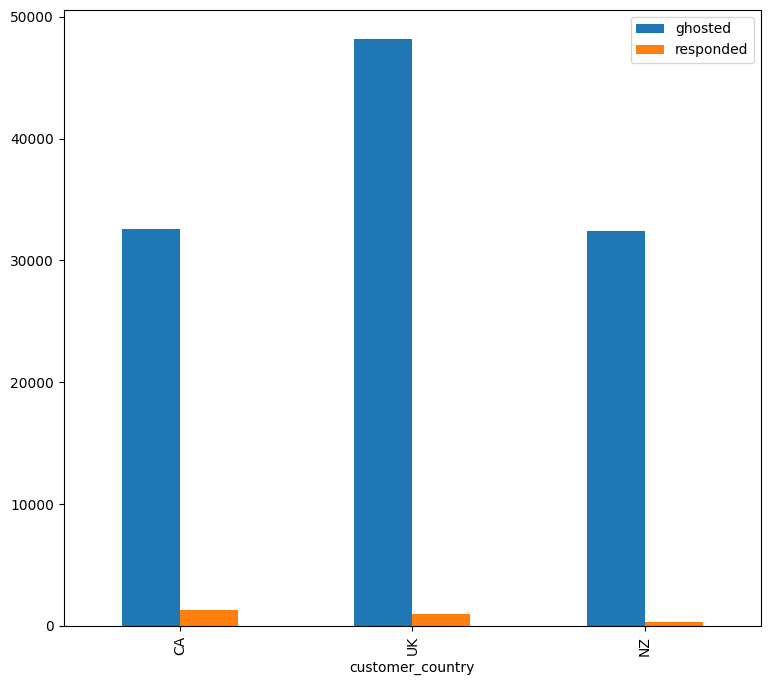

In [245]:
categorical_converted_splitter(df_csv, "customer_country")

In [246]:
print("Mean days in CA for people who RESPONDED: %s " % (df_last_messages["total_message_days"].loc[(df_last_messages['converted'] == 1) & (df_last_messages['client_country'] == 'CA')].mean()))
print("Mean days in CA for people who DIDN'T RESPOND: %s " % (df_last_messages["total_message_days"].loc[(df_last_messages['converted'] == 0) & (df_last_messages['client_country'] == 'CA')].mean()))
print()
print("Mean days in NZ for people who RESPONDED: %s " % (df_last_messages["total_message_days"].loc[(df_last_messages['converted'] == 1) & (df_last_messages['client_country'] == 'NZ')].mean()))
print("Mean days in NZ for people who DIDN'T RESPOND: %s " % (df_last_messages["total_message_days"].loc[(df_last_messages['converted'] == 0) & (df_last_messages['client_country'] == 'NZ')].mean()))
print()
print("Mean days in UK for people who RESPONDED: %s " % (df_last_messages["total_message_days"].loc[(df_last_messages['converted'] == 1) & (df_last_messages['client_country'] == 'UK')].mean()))
print("Mean days in UK for people who DIDN'T RESPOND: %s " % (df_last_messages["total_message_days"].loc[(df_last_messages['converted'] == 0) & (df_last_messages['client_country'] == 'UK')].mean()))
print()
print("Mean number of messages in CA for people who RESPONDED: %s " % (df_last_messages["message_number"].loc[(df_last_messages['converted'] == 1) & (df_last_messages['client_country'] == 'CA')].mean()))
print("Mean number of messages in CA for people who DIDN'T RESPOND: %s " % (df_last_messages["message_number"].loc[(df_last_messages['converted'] == 0) & (df_last_messages['client_country'] == 'CA')].mean()))
print()
print("Mean number of messages in NZ for people who RESPONDED: %s " % (df_last_messages["message_number"].loc[(df_last_messages['converted'] == 1) & (df_last_messages['client_country'] == 'NZ')].mean()))
print("Mean number of messages in NZ for people who DIDN'T RESPOND: %s " % (df_last_messages["message_number"].loc[(df_last_messages['converted'] == 0) & (df_last_messages['client_country'] == 'NZ')].mean()))
print()
print("Mean number of messages in UK for people who RESPONDED: %s " % (df_last_messages["message_number"].loc[(df_last_messages['converted'] == 1) & (df_last_messages['client_country'] == 'UK')].mean()))
print("Mean number of messages in UK for people who DIDN'T RESPOND: %s " % (df_last_messages["message_number"].loc[(df_last_messages['converted'] == 0) & (df_last_messages['client_country'] == 'UK')].mean()))

Mean days in CA for people who RESPONDED: 57.657832345469934 
Mean days in CA for people who DIDN'T RESPOND: 104.7258064516129 

Mean days in NZ for people who RESPONDED: 76.32939814814816 
Mean days in NZ for people who DIDN'T RESPOND: 115.97003389830508 

Mean days in UK for people who RESPONDED: 69.65153695225638 
Mean days in UK for people who DIDN'T RESPOND: 116.88277614335382 

Mean number of messages in CA for people who RESPONDED: 9.166807790008468 
Mean number of messages in CA for people who DIDN'T RESPOND: 15.828673835125448 

Mean number of messages in NZ for people who RESPONDED: 11.824074074074074 
Mean number of messages in NZ for people who DIDN'T RESPOND: 17.404745762711865 

Mean number of messages in UK for people who RESPONDED: 10.87573577501635 
Mean number of messages in UK for people who DIDN'T RESPOND: 17.551484354105376 


### Does age have anything to do with when they reply or not?

<AxesSubplot: xlabel='converted', ylabel='age'>

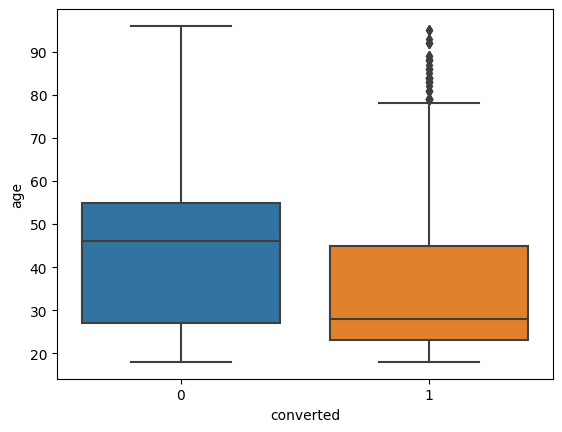

In [247]:
sns.boxplot(x="converted", y="age", data=df_last_messages)

<AxesSubplot: >

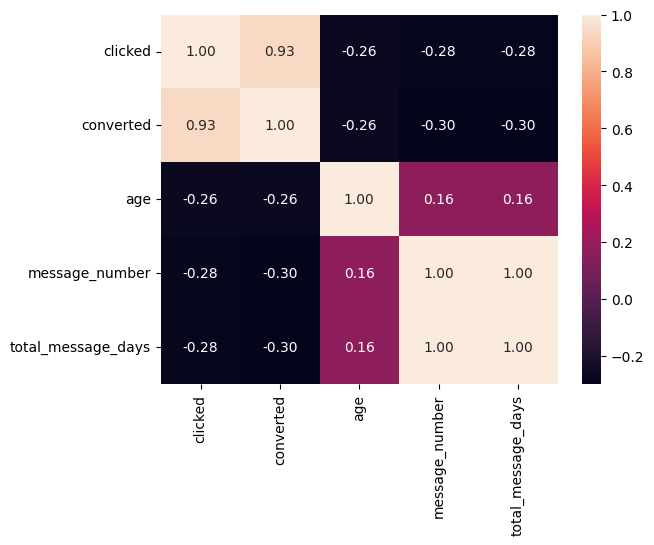

In [248]:
correlation_matrix_original = df_last_messages.corr(numeric_only=True)
sns.heatmap(correlation_matrix_original, annot=True,fmt=".2f")

<AxesSubplot: >

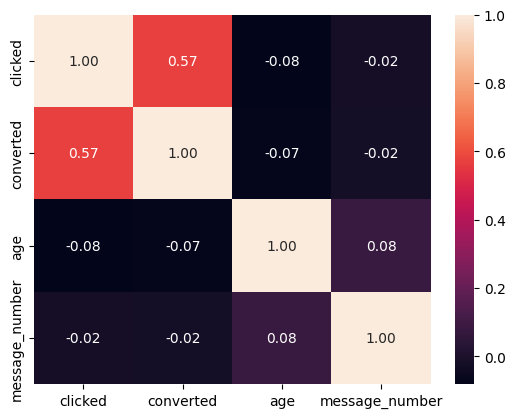

In [249]:
correlation_matrix_original = df_csv.corr(numeric_only=True)
sns.heatmap(correlation_matrix_original, annot=True,fmt=".2f")

heatmap of the correlation matrix for 1. the dataframe with the unique customer ids and if they replied or not vs 2. the dataframe with ALL the messages. The correlation on the latter's clicked and converted rates are worse since they included a lot of the 0 values whereas the formmer had way less rows and 0s. A higher age, number of final messages, and days before they either respond or stop getting messaged are slightly negatively correlated to the clicking and responding.

## 4. What are the main metrics, dimensions and filters to be included in the dashboard?

- Focused on the main factors, such as the clicks and replies over time, total customer replies, hour of the day replied, day of the week replied, and the channel replied. These are all split by customer countries. 
- Didn't go too much into the client companies since I assume InDebted reaches out to each customer the same regardless of client even if some clients have higher unresponsive rates. 
- Wanted to see if the product type mattered too but I felt that it would be too much content to include in the dashboard. 
- Thought of Age as a factor in relating to less responses due to it's negative correlation and boxplot but don't really feel it's a controllable factor. Unless things such as wording or other channels outside of email / sms are considered for older folks